In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
data = pd.read_csv("../artifacts/goodreads_reviews_spoiler_raw_cleaned.csv")

In [8]:
data.head(10)

,user_id,book_id,rating,review_text
0,8842281e1d1347389f2ab93d60773d4d,18245960,5,This is a special book. It started slow for ab...
1,8842281e1d1347389f2ab93d60773d4d,16981,3,Recommended by Don Katz. Avail for free in Dec...
2,8842281e1d1347389f2ab93d60773d4d,28684704,3,"A fun, fast paced science fiction thriller. I ..."
3,8842281e1d1347389f2ab93d60773d4d,27161156,0,Recommended reading to understand what is goin...
4,8842281e1d1347389f2ab93d60773d4d,25884323,4,"I really enjoyed this book, and there is a lot..."
5,8842281e1d1347389f2ab93d60773d4d,19398490,4,A beautiful story. It is rare to encounter a b...
6,8842281e1d1347389f2ab93d60773d4d,22318578,5,5 stars for giving me a better framework for h...
7,8842281e1d1347389f2ab93d60773d4d,24189224,0,Numerous people in publishing have told me thi...
8,8842281e1d1347389f2ab93d60773d4d,22551730,4,Another hard to put down nonfiction book from ...
9,8842281e1d1347389f2ab93d60773d4d,22816087,5,I love Stephenson - and this was another hit -...


## Data preprocessing

In [9]:
data.shape

(1378033, 4)

In [10]:
data.duplicated().sum()

np.int64(0)

In [11]:
data.isnull().sum()

user_id        0
book_id        0
rating         0
review_text    0
dtype: int64

In [ ]:
data = data[data['rating'] != 0]

In [ ]:
data.shape

In [13]:
# Detect language and select only English data
from lingua import Language, LanguageDetectorBuilder

detector = LanguageDetectorBuilder.from_languages(Language.ENGLISH).build()

def is_english_lingua(text):
    try:
        lang = detector.detect_language_of(str(text))
        return lang == Language.ENGLISH
    except:
        return False

data['is_english'] = data['review_text'].apply(is_english_lingua).reset_index(drop=True)
data = data[data['is_english'] == True].drop(columns=['is_english'])


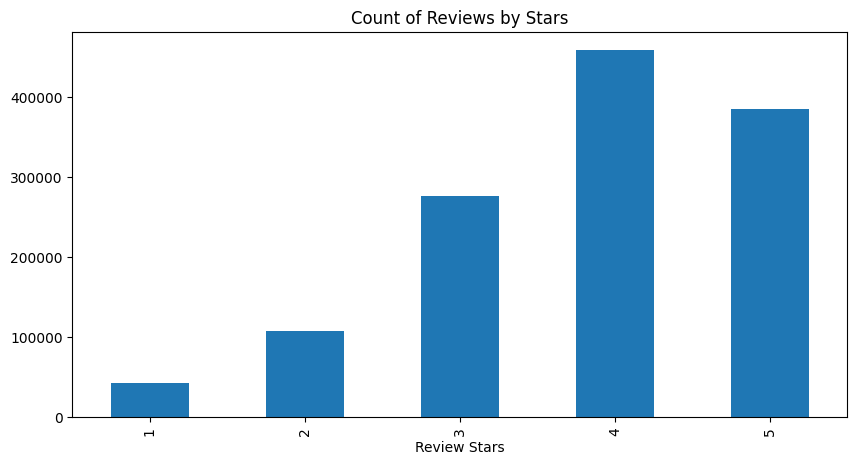

In [14]:
ax = data['rating']. value_counts().sort_index().plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize =(10,5))
ax.set_xlabel('Review Stars')
plt.show()

In [15]:
data = data.sample(n=500, random_state=123)

In [16]:

def sentiment(rating):
    if rating == 1:
        return 'very negative'
    elif rating == 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    elif rating == 4:
        return 'positive'
    elif rating == 5:
        return 'very positive'
    else:
        return 'unknown'  # or handle as you wish

data['sentiment'] = data['rating'].apply(sentiment)

In [17]:
data.head(5)

,user_id,book_id,rating,review_text,sentiment
211702,e4edbdeec83f032c2dc65a037f3868b8,17332218,5,This is one of those books that you can't put ...,very positive
726238,4a169982fff6697e23a9b685f2bc3e7d,20446140,3,3 stars \n Witch Hunt is the first book of Pre...,neutral
909020,e54f1889f59b2e34d8417789a5661339,17342701,4,"Honestly, when I started this series I didn't ...",positive
5924,b78a9143ca2f0c4c7361694dc6cb0500,304027,5,This series continues to impress. Loved V's st...,very positive
66420,c616bb2836e07560645b34e580697e37,8277481,4,A light contemporary read with plenty of laugh...,positive


## Text Preprocessing

In [18]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [19]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
# Preprocessing review text

def clean_text(text):
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    text = re.sub(r'http\S+|www\S+', '', text) # Remove URLs
    text = re.sub(r'\d+', '', text) # Remove digits
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove non-alphabetic characters
    text = text.lower() # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')]) # Remove all stop words
    return text

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()]) # Lemmatization

data['review_text'] = data['review_text'].apply(clean_text).apply(lemmatize_text)


In [21]:
data["review_text"].head(10)

211702     one book cant put cant bear finish time even w...
726238     star witch hunt first book preternatural affai...
909020     honestly started series didnt think would like...
5924       series continues impress loved v story fastpac...
66420      light contemporary read plenty laughoutloud mo...
1301781    annabel keeping lot secret hate modeling somet...
250945     story star character development star proselan...
816737     im ambivalent edit star first id like point re...
770920     thought cute entertaining girly book look like...
810791     oh freaking god im starting let greatness begi...
Name: review_text, dtype: object

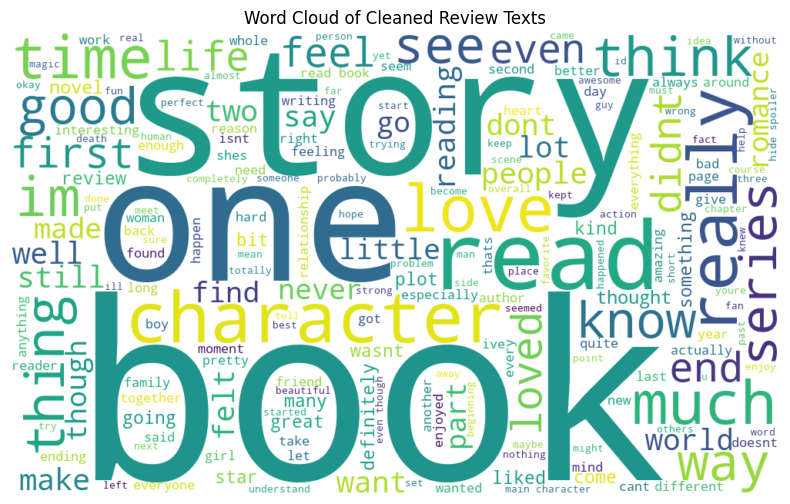

In [22]:
from wordcloud import WordCloud

# Join all cleaned review texts into one string
all_text = " ".join(data['review_text'])

# Generate word cloud
wordcloud = WordCloud(width=1000, height=600, background_color='white', colormap='viridis').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Review Texts')
plt.show()


## Sentiment Analysis

In [23]:
from sklearn.model_selection import train_test_split

data = data[data['rating'].isin([1,2,3,4,5])].copy()
data['label'] = data['rating'] - 1

train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

In [24]:
import torch
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item


In [25]:
from transformers import AutoTokenizer

model_names = {
    "xlnet": "xlnet-base-cased",
    "bert": "bert-base-uncased",
    "distilbert": "distilbert-base-uncased",
    "albert": "albert-base-v2",
    "roberta": "roberta-base",
    "electra": "google/electra-base-discriminator"
}

# Optional: Can remove if not used
tokenizers = {name: AutoTokenizer.from_pretrained(model) for name, model in model_names.items()}

In [26]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0,1,2,3,4]),
    y=train_data['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [27]:
from torch.nn import CrossEntropyLoss

def train_one_epoch(model, dataloader, optimizer, device, class_weights):
    model.train()
    total_loss = 0
    loss_fn = CrossEntropyLoss(weight=class_weights)
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pred = outputs.logits.argmax(dim=1).cpu().numpy()
            preds.extend(pred)
            labels.extend(label.cpu().numpy())
    return preds, labels


In [ ]:
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = {}
metrics = {}

for name, model_name in model_names.items():
    print(f"\nFine-tuning {name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5).to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)

    train_dataset = SentimentDataset(train_data['review_text'].tolist(), train_data['label'].tolist(), tokenizer)
    val_dataset = SentimentDataset(val_data['review_text'].tolist(), val_data['label'].tolist(), tokenizer)
    test_dataset = SentimentDataset(test_data['review_text'].tolist(), test_data['label'].tolist(), tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)

    for epoch in range(2):
        train_loss = train_one_epoch(model, train_loader, optimizer, device,class_weights)
        print(f"Epoch {epoch+1} - Train loss: {train_loss:.4f}")

    test_preds, test_labels = evaluate(model, test_loader, device)
    results[name] = test_preds
    metrics[name] = {
        "accuracy": accuracy_score(test_labels, test_preds),
        "precision": precision_score(test_labels, test_preds, average='weighted', zero_division=0),
        "recall": recall_score(test_labels, test_preds, average='weighted', zero_division=0),
        "f1": f1_score(test_labels, test_preds, average='weighted', zero_division=0)
    }
    print(f"Test metrics for {name}: {metrics[name]}")


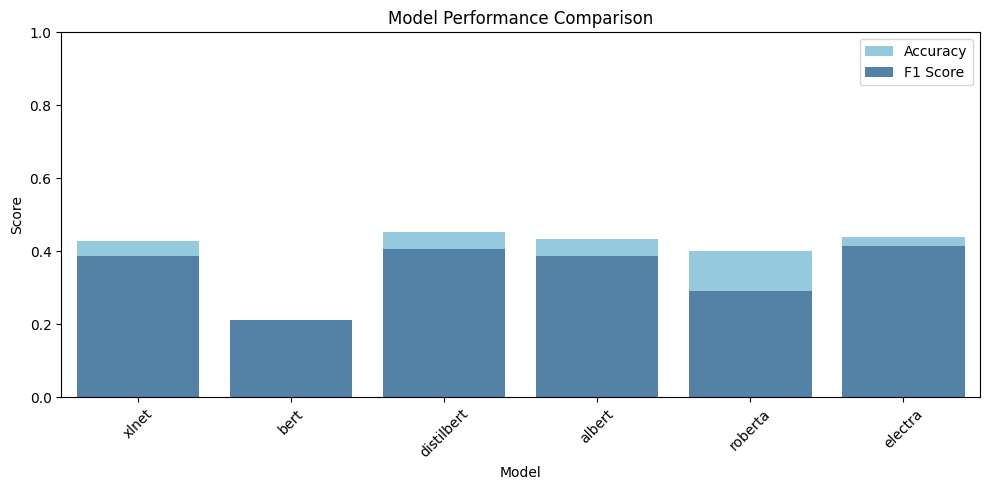

In [ ]:

import seaborn as sns

metrics_df = pd.DataFrame(metrics).T.reset_index().rename(columns={'index': 'model'})

# Plot accuracy and F1-score
plt.figure(figsize=(10, 5))
sns.barplot(x='model', y='accuracy', data=metrics_df, color='skyblue', label='Accuracy')
sns.barplot(x='model', y='f1', data=metrics_df, color='steelblue', label='F1 Score')

plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

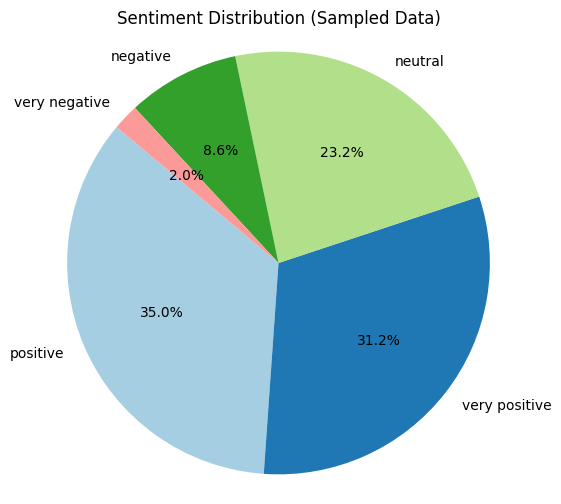

In [ ]:
sentiment_counts = data['sentiment'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Sentiment Distribution (Sampled Data)')
plt.axis('equal')
plt.show()

Confusion Matrix for xlnet:


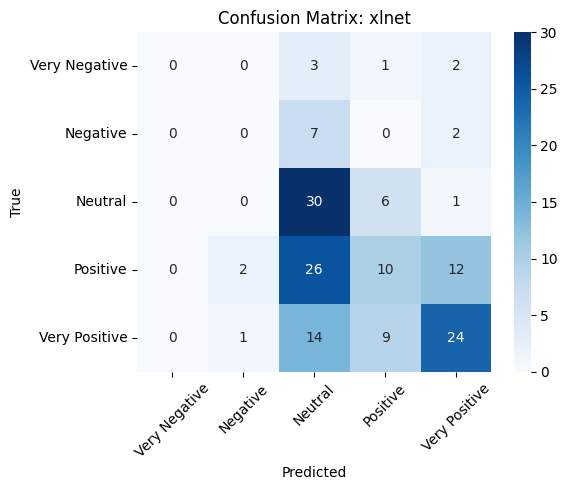

Confusion Matrix for bert:


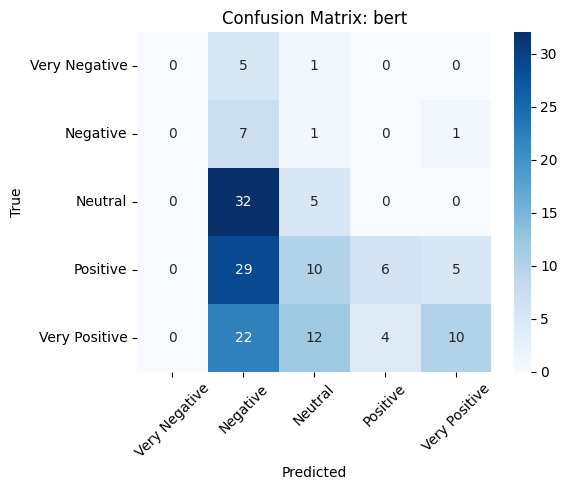

Confusion Matrix for distilbert:


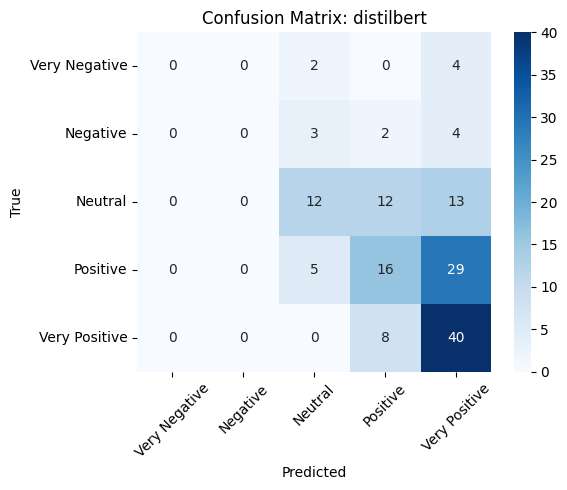

Confusion Matrix for albert:


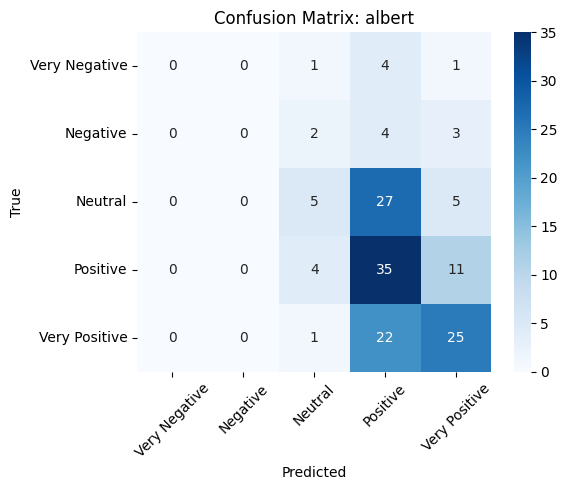

Confusion Matrix for roberta:


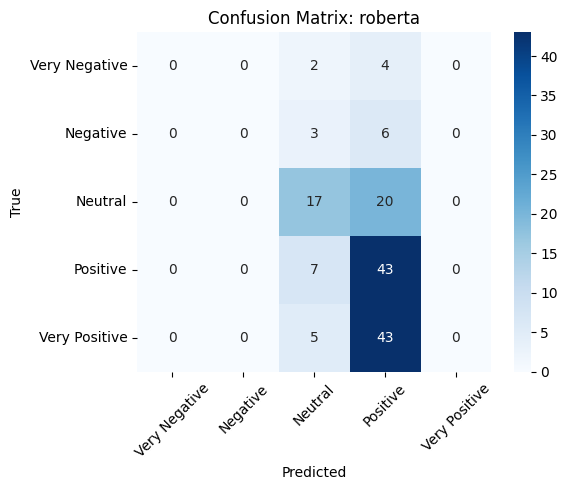

Confusion Matrix for electra:


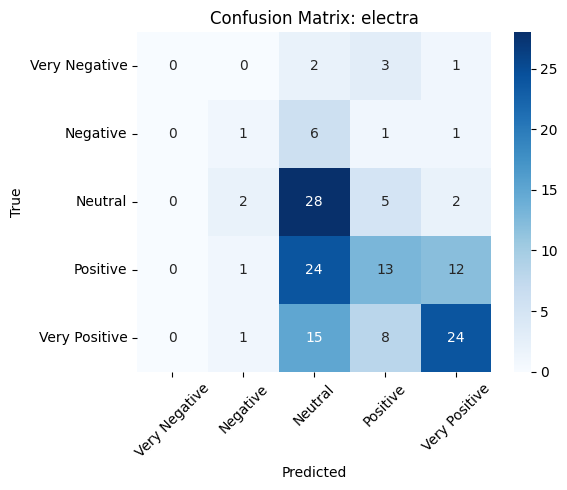

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot confusion matrix for each model
for name in results:
    print(f"Confusion Matrix for {name}:")
    plot_confusion_matrix(test_labels, results[name], name)
